In [1]:
# SETUP

import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

plt.rcParams.update({'font.size': 13}) # Set font size globally

from scipy.fft import fft, fftfreq

# Parameters
n_atoms = 1728

speed_c = 2.997*1e8 # m/s
epsilon_0 = 8.854*1e-12 # F/m = C²/J*m
k_B = 1.3806*1e-23 # J/K
pi = np.pi

# See "avg_vol.txt" for the fixed volume
known_step = 50001
dt_fs = 0.5 # Time step in fs
# LAMMPS units = real, dipole = charge*Angstroms or e*Angstroms... need to convert e to C

convert_dipole = ((1.6022e-19)*(1e-10)/1e-15)**2 # convert e to C, A to m, and fs to s now in (C*m/s)²

rdf_peaks = np.loadtxt("see_RDF_first_peaks.txt")

In [2]:
# Create a dictionary mapping temperature to peak radius

peak_by_temp = {int(row[0]): row[1] for row in rdf_peaks}

In [3]:
# Helper function to extract from filename

def file_get_temp(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else None

In [4]:
# Helper function to extract temperature from filename

def file_sort_by_temp(pattern):
    files = sorted(glob.glob(pattern), key=file_get_temp)
    return {file_get_temp(f): f for f in files}

In [5]:
# Collect files

all_files = sorted(glob.glob("dacf_n_dt*.txt"), key=file_get_temp)

In [6]:
# Load all DACF files into temperature-indexed dictionaries

all_dacf_by_temp = file_sort_by_temp("dacf_n_dt*.txt")

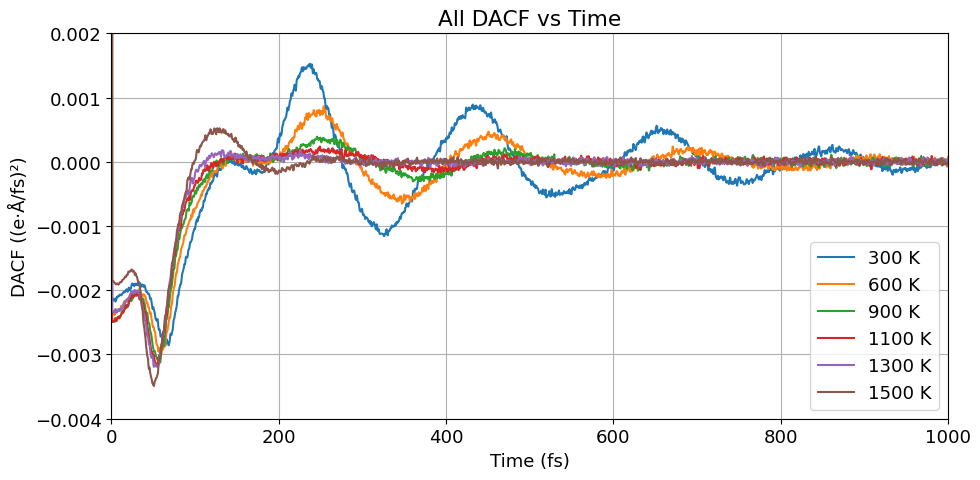

In [7]:
# DACF plotting function

def plot_dacf_set(file_list, label, output_name):
    plt.figure(figsize=(10, 5))

    for filename in file_list:
        temp = file_get_temp(filename)
        dacf = np.loadtxt(filename)
        time = np.arange(len(dacf)) * dt_fs
        plt.plot(time, dacf, label=f"{temp} K")

    plt.title(f"{label} DACF vs Time")
    plt.xlabel("Time (fs)")
    plt.ylabel("DACF ((e⋅Å/fs)²)")
    plt.grid(True)
    plt.ylim(-0.004, 0.002)
    plt.xlim(0, 1000)
    plt.legend()
    #plt.legend(loc='lower right', bbox_to_anchor=(0.95, 1))
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=600)
    plt.show() # plt.close()

# Plot and save each DACF group
plot_dacf_set(all_files, "All", "croppedDACF_all")

# print("Plots saved: DACF_all.png")

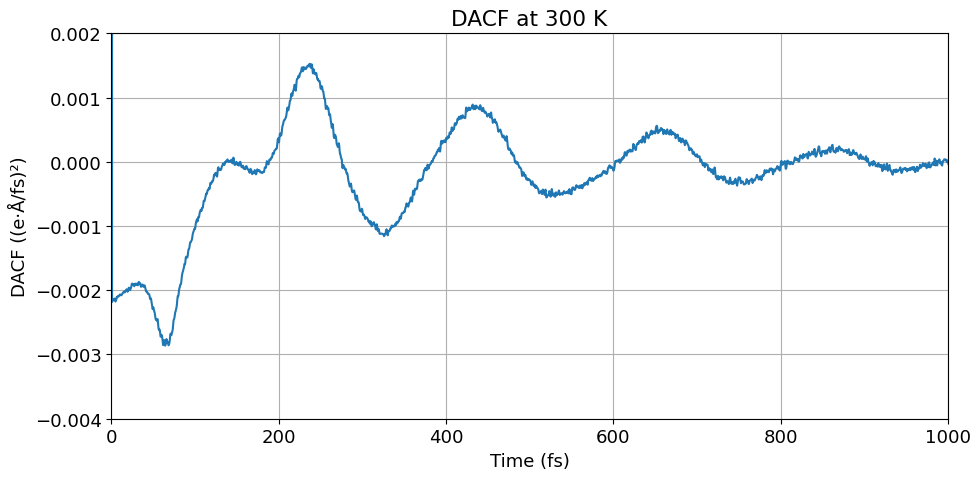

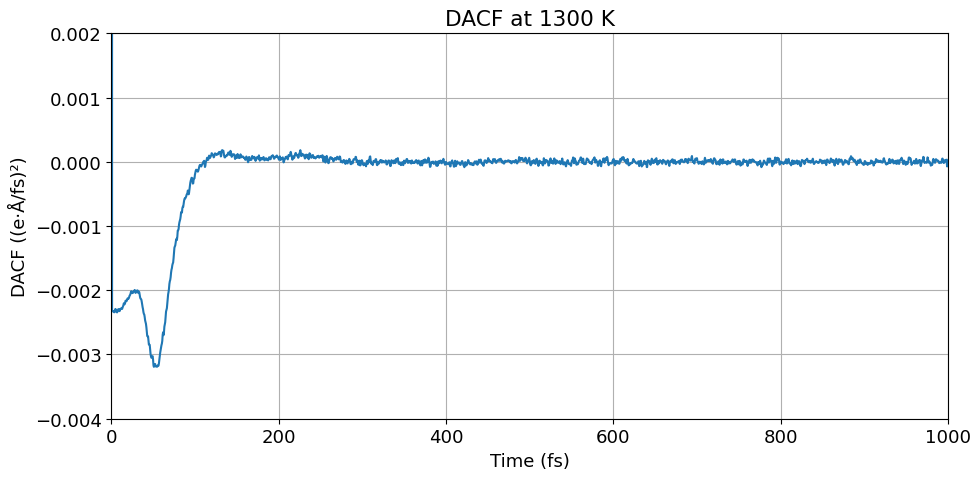

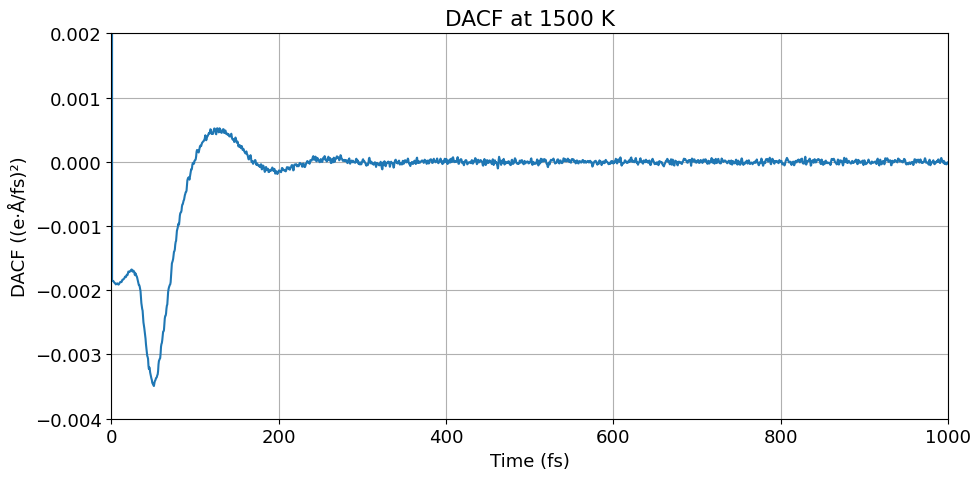

In [8]:
def plot_dacf_by_temperature(temps_to_plot):
    for temp in temps_to_plot:
        if temp not in all_dacf_by_temp: 
            print(f"Skipping {temp} K (data missing)")
            continue

        # Load each DACF curve
        dacf_all = np.loadtxt(all_dacf_by_temp[temp])

        time = np.arange(len(dacf_all)) * dt_fs

        plt.figure(figsize=(10, 5))
        plt.plot(time, dacf_all)
        plt.title(f"DACF at {temp} K")
        plt.xlabel("Time (fs)")
        plt.ylabel("DACF ((e⋅Å/fs)²)")
        plt.ylim(-0.004, 0.002)
        plt.xlim(0, 1000)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{temp}cropDACF.png", dpi=600)
        plt.show()

plot_dacf_by_temperature([300, 1300, 1500])

In [9]:
def compute_fft(acf, dt_fs, output_freq_unit='THz'):
    """
    Compute the Fourier transform of an autocorrelation function.

    Parameters:
    - acf : 1D numpy array of ACF values
    - dt_fs : timestep duration in femtoseconds
    - output_freq_unit : 'Hz', 'THz', or 'rad/s'

    Returns:
    - freqs : frequencies (in desired unit)
    - spectrum : real part of the FFT of the ACF
    """
    
    # Convert timestep from fs to seconds
    dt = dt_fs * 1e-15  # [s]

    # Number of time points
    N = len(acf)

    # FFT
    spectrum = fft(acf)
    spectrum_real = np.real(spectrum)
    spectrum_imag = np.imag(spectrum)
    spectrum_power = np.abs(spectrum)**2

    # Frequencies (in Hz by default)
    freqs = fftfreq(N, d=dt)

    # Convert frequency units
    if output_freq_unit == 'THz':
        freqs /= 1e12
    elif output_freq_unit == 'rad/s':
        freqs *= 2 * pi
    # Else keep in Hz

    # Extract only positive frequencies... necessary to multiply by the sampling period because I want the continuous fourier transform
    # This function computes the one-dimensional n-point discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT) algorithm
    mask = freqs > 0
    freqs = freqs[mask]
    spectrum = spectrum[mask] * dt
    spectrum_real = spectrum_real[mask] * dt
    spectrum_imag = spectrum_imag[mask] * dt
    spectrum_power = spectrum_power[mask] * dt

    return freqs, spectrum_real, spectrum_imag, spectrum_power

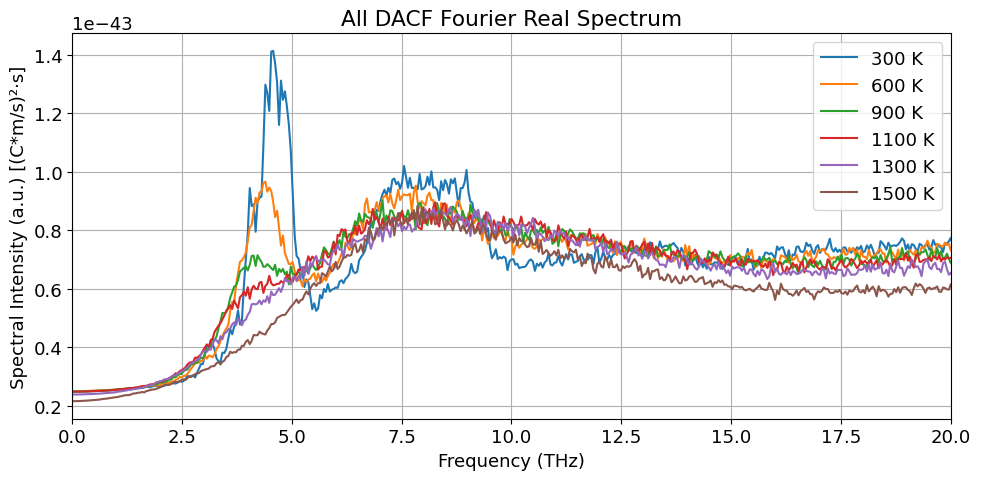

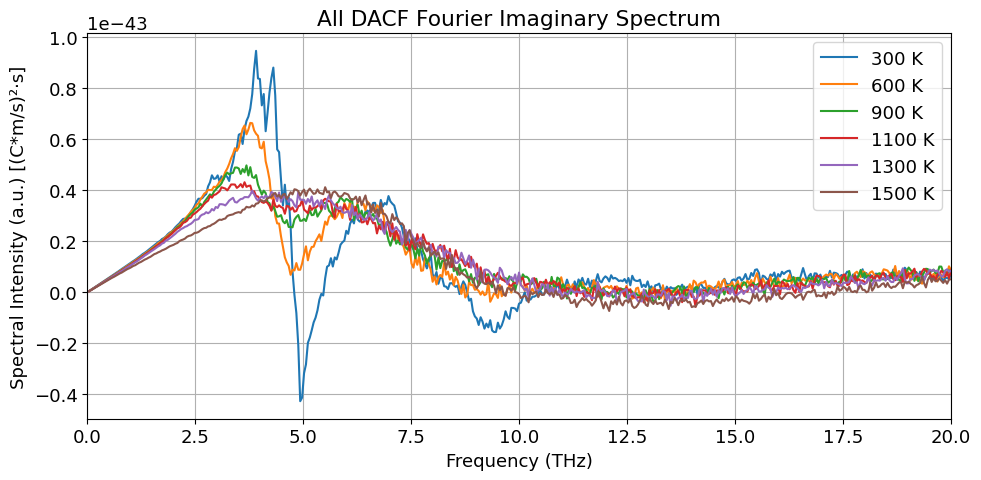

In [10]:
# Fourier plotting function

def plot_fourier_r(file_list, label): # output_name
    plt.figure(figsize=(10, 5))
    for file in file_list:
        temp = file_get_temp(file)
        acf = np.loadtxt(file)
        freqs, spectrum, _, _ = compute_fft(acf[:int(0.90 * len(acf))]*convert_dipole, dt_fs, output_freq_unit='THz')
        plt.plot(freqs, spectrum, label=f"{temp} K")
    plt.title(f"{label} DACF Fourier Real Spectrum")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Spectral Intensity (a.u.) [(C*m/s)²⋅s]")
    plt.grid(True)
    plt.xlim(0, 20)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{output_name}.png", dpi=600)
    plt.show() # plt.close()

def plot_fourier_i(file_list, label): # output_name
    plt.figure(figsize=(10, 5))
    for file in file_list:
        temp = file_get_temp(file)
        acf = np.loadtxt(file)
        freqs, _, spectrum, _ = compute_fft(acf[:int(0.90 * len(acf))]*convert_dipole, dt_fs, output_freq_unit='THz')
        plt.plot(freqs, spectrum, label=f"{temp} K")
    plt.title(f"{label} DACF Fourier Imaginary Spectrum")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Spectral Intensity (a.u.) [(C*m/s)²⋅s]")
    plt.grid(True)
    plt.xlim(0, 20)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{output_name}.png", dpi=600)
    plt.show() # plt.close()

# Generate plots
plot_fourier_r(all_files, "All") #, "DACF_Fourier_all_r")
plot_fourier_i(all_files, "All") #, "DACF_Fourier_all_i")

# print("Fourier plots saved: DACF_Fourier_all.png")

C:\Users\asjug\AppData\Local\Temp\ipykernel_28344\4095529042.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


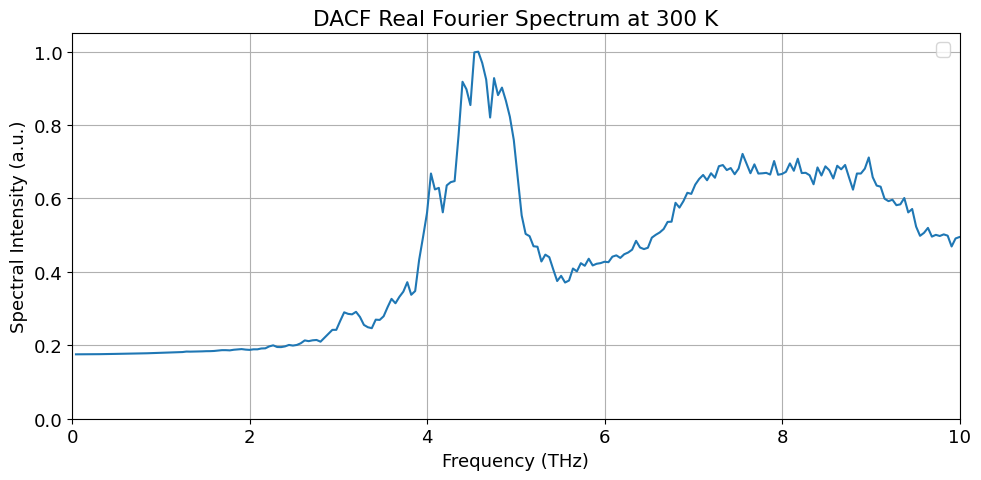

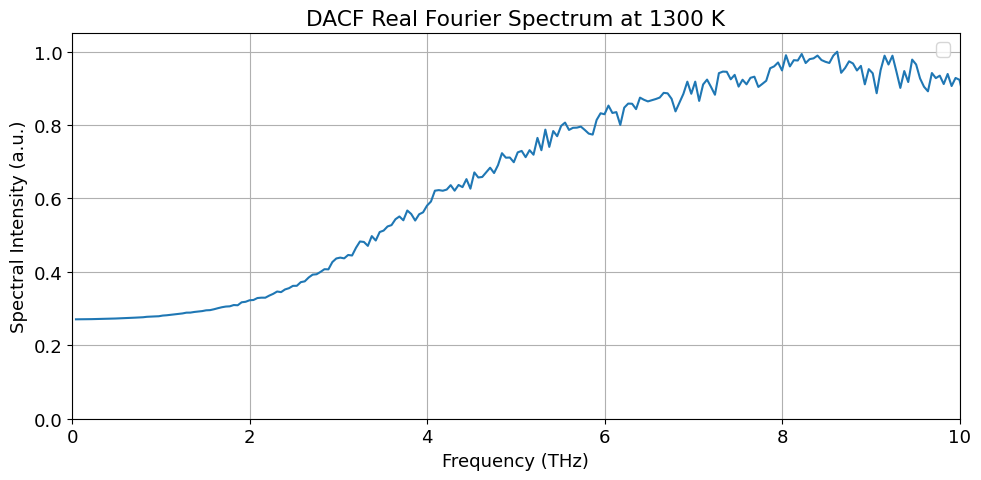

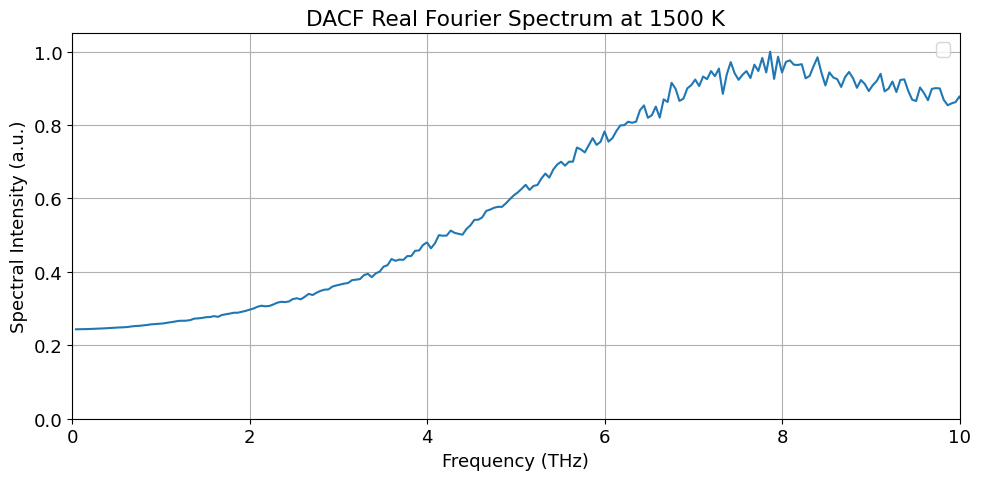

In [11]:
def plot_fourier_by_temperature(temps_to_plot):
    for temp in temps_to_plot:
        if temp not in all_dacf_by_temp:
            print(f"Skipping {temp} K (data missing)")
            continue

        # Load ACFs
        acf_all = np.loadtxt(all_dacf_by_temp[temp])

        # Compute FFT
        freqs_all, spectrum_r, spectrum_i, _ = compute_fft(acf_all[:int(0.90 * len(acf_all))]*convert_dipole, dt_fs, output_freq_unit='THz')

        # Normalize
        max_val = max(np.max(np.abs(spectrum_r)), np.max(np.abs(spectrum_i)))
        spectrum_r = spectrum_r / max_val
        spectrum_i = spectrum_i / max_val

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_all, spectrum_r)#, label='Real')
        #plt.plot(freqs_all, spectrum_i, linestyle='--', label='Imaginary')

        plt.title(f"DACF Real Fourier Spectrum at {temp} K")
        plt.xlabel("Frequency (THz)")
        plt.ylabel("Spectral Intensity (a.u.)") #[(C⋅m/s)²⋅s]
        plt.grid(True)
        plt.xlim(0, 10)
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{temp}_fourier.png", dpi=600)
        plt.show()

plot_fourier_by_temperature([300, 1300, 1500])

In [12]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyElli
from elli.kkr.kkr import im2re

In [13]:
def KK_pyElli(nu_vals, e_i_vals):
    """
    Computes ε'(ν) = https://pyelli.readthedocs.io/en/stable/kkr.html
    Inputs:
        nu_vals      : array of frequencies ν where we want ε'(ν)
        e_i_vals     : array of imaginary dielectric ε''(ν) 
    Returns:
        e_r_vals     : array of real dielectric ε'(ν)
    """
            
    # Ensure numpy arrays
    nu_vals = np.asarray(nu_vals)
    e_i_vals = np.asarray(e_i_vals)

    e_r_vals = im2re(e_i_vals, nu_vals)
           
    return e_r_vals

In [14]:
def get_complex_n(e_r, e_i):
    epsilon_abs = np.sqrt(e_r**2 + e_i**2)
    n_real = np.sqrt((epsilon_abs + e_r) / 2)
    n_imag = (e_i) / (2*n_real)
    return n_real, n_imag

In [15]:
def compute_dielectric_refractive(acf, radius, temp):
    # Compute FFT
    freqs, spectrum_real, _, _ = compute_fft(acf[:int(0.90 * len(acf))]*convert_dipole, dt_fs, output_freq_unit='THz')

    fixed_T = temp

    # NOTE: Intensity units are arbitrary here
        
    # Now I will make absorption spectrum to extract dielectric properties
        
    # In these calculations, the refractive index/dielectric constant is complex and a function of frequency
    # n(nu) = n'(nu) + in''(nu), n'(nu) = n_r, n''(nu) = n_i
    # e(nu) = e'(nu) + ie''(nu), e'(nu) = e_r, e''(nu) = e_i
        
    fixed_vol = (4/3)*pi*(radius**3) / 1e30
        
    constants = 1/(6*speed_c*epsilon_0*k_B*fixed_T) # Where these constants have units [(m/s) * m^3 * (C²/J*m) * (J/K) * K]^-1
        
    #alpha(nu) * n'(nu) = constants * fourier transform (ACF of dipole derivative)... in this case, I am using the magnitude of the Fourier transform
    alpha_n_r = (constants/fixed_vol)*(2*spectrum_real)
        
    # Using the magnitude since the alpha term has the imaginary component in it along with being multiplied with the real component
    # Where the fourier transform has units: [(C*m/s)²⋅s] -> alpha_n_r has units of m^-1
        
    print(constants)
    print(freqs)
        
    # alpha(nu) * n'(nu) = KNOWN
        
    # e''(nu) = (c / (2*pi*nu)) * (alpha(nu) * n'(nu)) --> ensure the right units for frequency
    e_i = (speed_c / (2*pi*freqs*1e12)) * alpha_n_r # frequency UNITS in THz and m^-1 for alpha_n_r --> UNITS for e_i = (Hz*s)^-1 = UNITLESS

    # NOTE: nu = ν
        
    # PREVIOUSLY: e'(ν) = 4 int^infty_0 int^infty_0 e''(ν') * sin(ν'*t) * cos(ν*t) d ν' dt
        
    # CURRENT: elli.kkr.kkr.im2re(im, x)
            
    # I have ν' up to 1000 THz -> 1e15 Hz, and a known ε''(ν), we want ε'(ν) at the following points
    nu_array = (freqs*1e12)
        
    e_r = KK_pyElli(nu_array, e_i) #UNITLESS
                
    # Now I can use the real and imaginary parts of epsilon to calculate the complex refractive index
    # Consider that n²(nu) = e(nu)
        
    # n' + in'' = sqrt(e' + ie'')
    # n' = +/- sqrt( 1/2 * [sqrt(e'² + e''²) + e'] ) = n_r
    # n'' = +/- sqrt( 1/2 * [sqrt(e'² + e''²) - e'] ) = n_i
        
        #def get_complex_n(e_r, e_i):
        
    n_r, n_i = get_complex_n(e_r, e_i)
        
    #print("ν (Hz)          n'(ν) (unitless)          n''(ν) (unitless)")
    #for x, y, z in zip(nu_array, n_r, n_i):
    #    print(f"{x:6.2f}  {y:12.8f}  {z:12.8f}")

    abs_coeff = alpha_n_r/n_r
    
    return freqs, alpha_n_r, e_i, e_r, n_r, n_i, nu_array, abs_coeff

In [16]:
def compute_dielectric_refractive_for_all_files(file_list):
    results = []
    for file in file_list:
        temp = file_get_temp(file)
        acf = np.loadtxt(file)
        radius = peak_by_temp.get(int(temp))
        freqs, alpha_n_r, e_i, e_r, n_r, n_i, nu_array, abs_coeff = compute_dielectric_refractive(acf, radius, temp)
        results.append({
            'temp': temp,
            'freqs': freqs,
            'alpha_n_r': alpha_n_r, 
            'e_i': e_i,
            'e_r': e_r,
            'n_r': n_r,
            'n_i': n_i,
            'nu': nu_array,
            'abs_coeff': abs_coeff
        })
    return results

results_all = compute_dielectric_refractive_for_all_files(all_files)

1.5164684010304831e+22
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]
7.582342005152416e+21
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]
5.05489467010161e+21
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]
4.1358229119013177e+21
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]
3.4995424639165e+21
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]
3.032936802060967e+21
[4.44444444e-02 8.88888889e-02 1.33333333e-01 ... 9.99866667e+02
 9.99911111e+02 9.99955556e+02]


C:\Users\asjug\AppData\Local\Temp\ipykernel_28344\1824629334.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


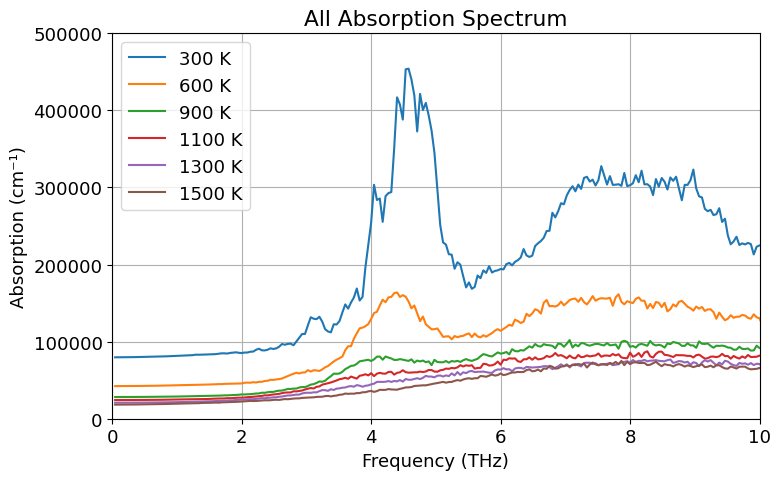

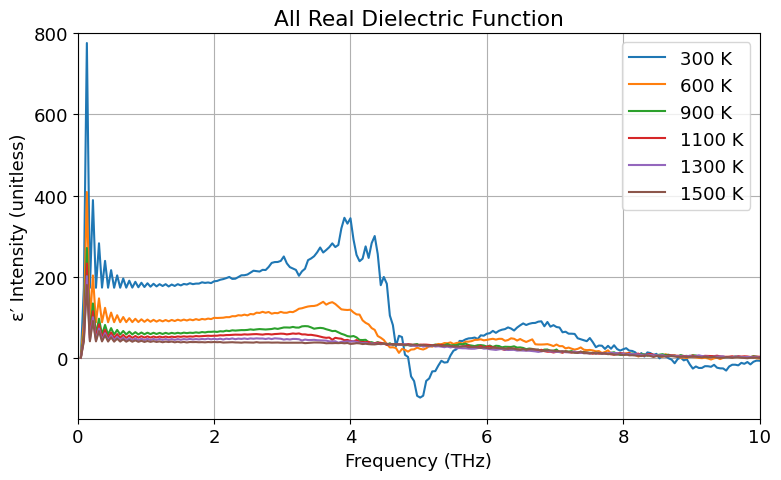

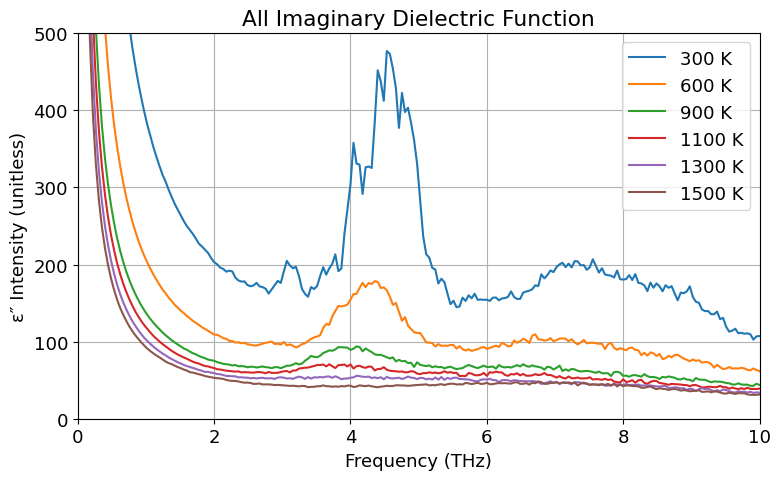

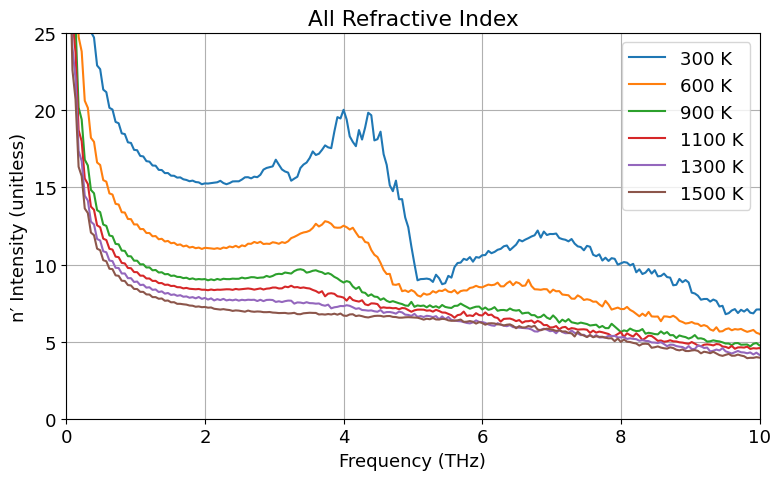

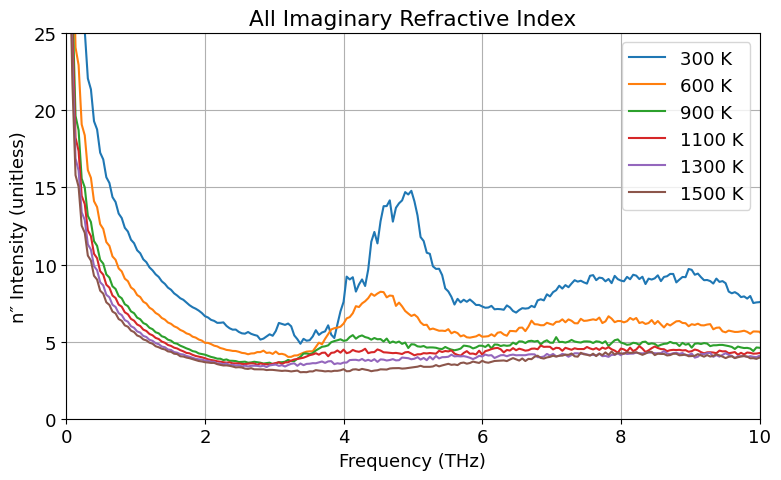

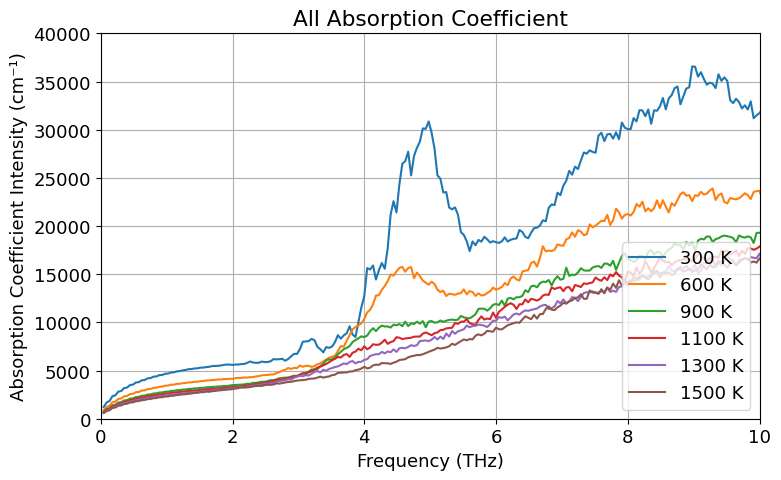

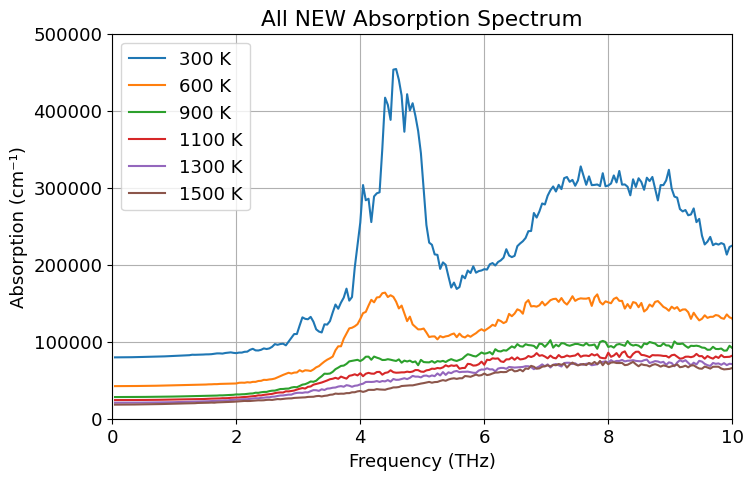

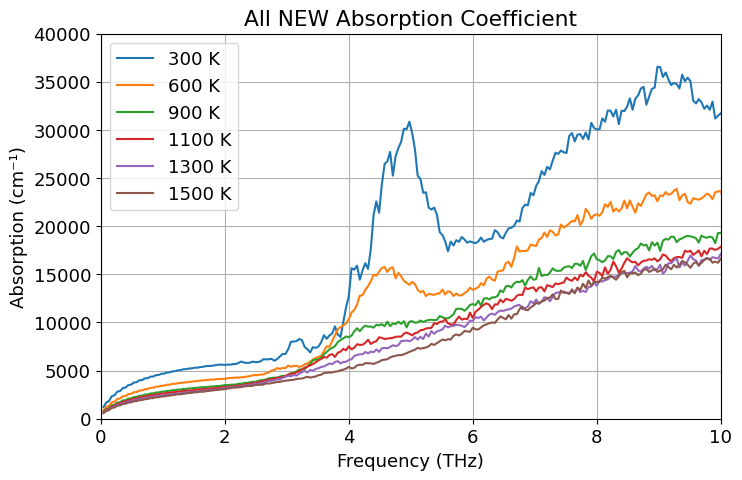

In [32]:
fig_absp, ax_absp = plt.subplots(figsize=(8,5))
fig_die_r, ax_die_r = plt.subplots(figsize=(8,5))
fig_die_i, ax_die_i = plt.subplots(figsize=(8,5))
fig_ref_r, ax_ref_r = plt.subplots(figsize=(8,5))
fig_ref_i, ax_ref_i = plt.subplots(figsize=(8,5))
fig_absc, ax_absc = plt.subplots(figsize=(8,5))

fig_absp_n, ax_absp_n = plt.subplots(figsize=(8,5))
fig_absc_n, ax_absc_n = plt.subplots(figsize=(8,5))

def plot_dielectric_refractive(results, label):
    for data in results:
        temp = data['temp']
        ax_absp.plot(data['nu']/1e12, data['alpha_n_r']/100, label=f"{temp} K") #data['freqs']*1e12/(speed_c*100)
        ax_die_r.plot(data['nu']/1e12, data['e_r'], label=f"{temp} K")
        ax_die_i.plot(data['nu']/1e12, data['e_i'], label=f"{temp} K")
        ax_ref_r.plot(data['nu']/1e12, data['n_r'], label=f"{temp} K")
        ax_ref_i.plot(data['nu']/1e12, data['n_i'], label=f"{temp} K")
        ax_absc.plot(data['nu']/1e12, data['abs_coeff']/100, label=f"{temp} K")

        # This is the absoprtion coefficient calculated from the refractive index, not the absorption spectrum, should match
        abs_coeff_n = (4*pi*(data['nu']/(speed_c*100))*data['n_i'])

        ax_absp_n.plot(data['nu']/1e12, abs_coeff_n*data['n_r'], label=f"{temp} K")
        ax_absc_n.plot(data['nu']/1e12, abs_coeff_n, label=f"{temp} K")


    # Plot absorption spectrum
    
    ax_absp.set_xlabel('Frequency (THz)') #Wavenumber (cm⁻¹)
    ax_absp.set_ylabel('Absorption (cm⁻¹)')
    ax_absp.set_title(f"{label} Absorption Spectrum")
    #ax_absp.set_xlim(0, 330)
    ax_absp.set_xlim(0, 10)
    ax_absp.set_ylim(0, 500000)
    ax_absp.legend()
    ax_absp.grid(True)

    # Plot dielectric function

    ax_die_r.set_xlabel('Frequency (THz)')
    ax_die_r.set_ylabel('ε′ Intensity (unitless)')
    ax_die_r.set_title(f"{label} Real Dielectric Function")
    ax_die_r.set_xlim(0, 10)
    ax_die_r.set_ylim(-150, 800)
    ax_die_r.legend()
    ax_die_r.grid(True)

    ax_die_i.set_xlabel('Frequency (THz)')
    ax_die_i.set_ylabel('ε″ Intensity (unitless)')
    ax_die_i.set_title(f"{label} Imaginary Dielectric Function")
    ax_die_i.set_xlim(0, 10)
    ax_die_i.set_ylim(0, 500)
    ax_die_i.legend()
    ax_die_i.grid(True)

    # Plot refractive index

    ax_ref_r.set_xlabel('Frequency (THz)')
    ax_ref_r.set_ylabel('n′ Intensity (unitless)')
    ax_ref_r.set_title(f"{label} Refractive Index") # REAL
    ax_ref_r.set_xlim(0, 10)
    ax_ref_r.set_ylim(0, 25)
    ax_ref_r.legend()
    ax_ref_r.grid(True)

    ax_ref_i.set_xlabel('Frequency (THz)')
    ax_ref_i.set_ylabel('n″ Intensity (unitless)')
    ax_ref_i.set_title(f"{label} Imaginary Refractive Index")
    ax_ref_i.set_xlim(0, 10)
    ax_ref_i.set_ylim(0, 25)
    ax_ref_i.legend()
    ax_ref_i.grid(True)

    ax_absc.set_xlabel('Frequency (THz)')
    ax_absc.set_ylabel('Absorption Coefficient Intensity (cm⁻¹)')
    ax_absc.set_title(f"{label} Absorption Coefficient")
    ax_absc.set_xlim(0, 10)
    ax_absc.set_ylim(0, 40000)
    ax_absc.legend()
    ax_absc.legend(loc='lower right')
    ax_absc.grid(True)

    # New absorption spectrum by using the imaginary part of the refractive index to calculate the absorption coefficient
    # NOTE: the below should match with the original absorption spectrum. 

    ax_absp_n.set_xlabel('Frequency (THz)') #Wavenumber (cm⁻¹)
    ax_absp_n.set_ylabel('Absorption (cm⁻¹)')
    ax_absp_n.set_title(f"{label} NEW Absorption Spectrum")
    #ax_absp_n.set_xlim(0, 330)
    ax_absp_n.set_xlim(0, 10)
    ax_absp_n.set_ylim(0, 500000)
    ax_absp_n.legend()
    ax_absp_n.grid(True)

    ax_absc_n.set_xlabel('Frequency (THz)') #Wavenumber (cm⁻¹)
    ax_absc_n.set_ylabel('Absorption (cm⁻¹)')
    ax_absc_n.set_title(f"{label} NEW Absorption Coefficient")
    #ax_absc_n.set_xlim(0, 330)
    ax_absc_n.set_xlim(0, 10)
    ax_absc_n.set_ylim(0, 40000)
    ax_absc_n.legend()
    ax_absc_n.grid(True)

plot_dielectric_refractive(results_all, "All")

figures = [
    (fig_absp, "absorption"),
    (fig_die_r, "dielectric_real"),
    (fig_die_i, "dielectric_imag"),
    (fig_ref_r, "refractive_real"),
    (fig_ref_i, "refractive_imag"),
    (fig_absc, "abs_coeff")
]

for fig, name in figures:
    fig.tight_layout()
    fig.savefig(f"{name}_all.png", dpi=600)
    fig.show()

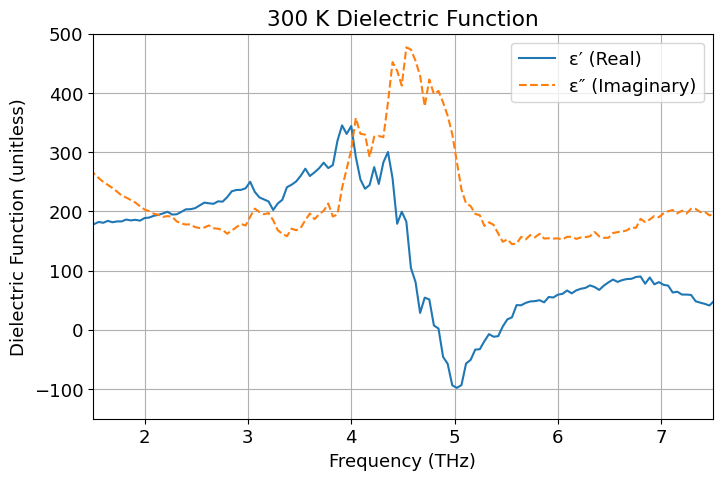

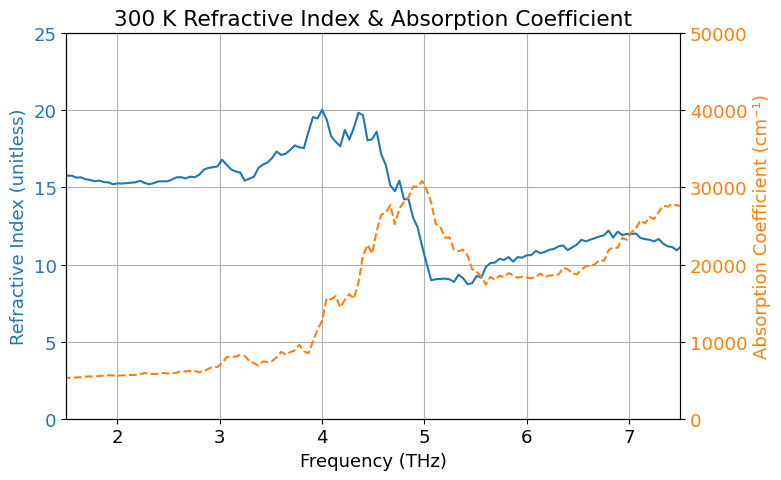

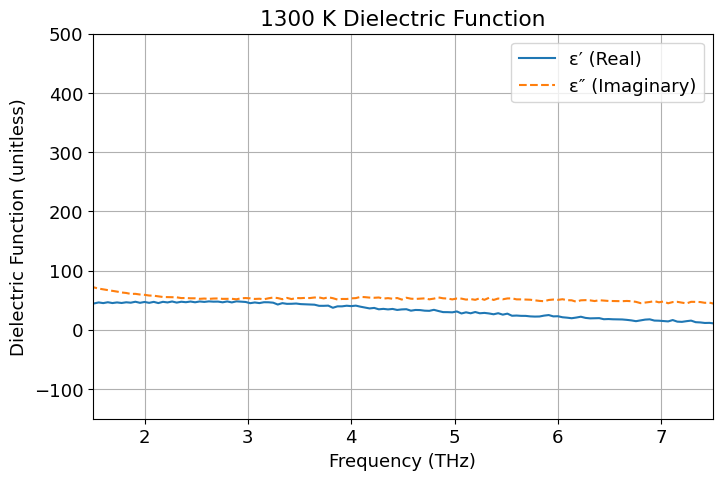

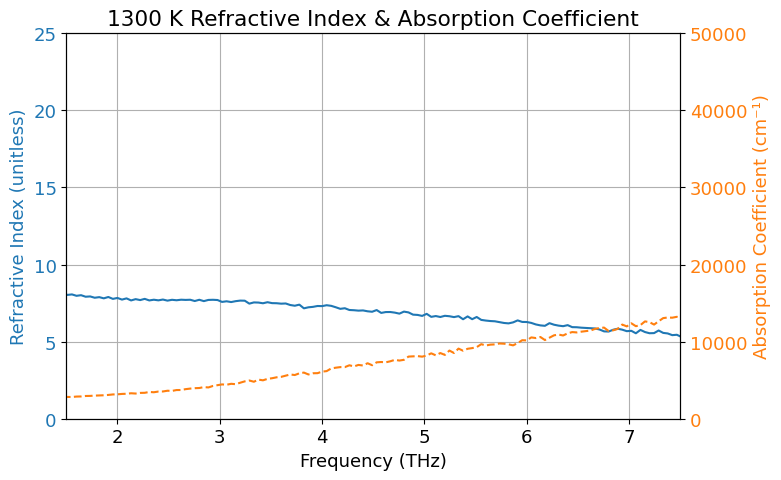

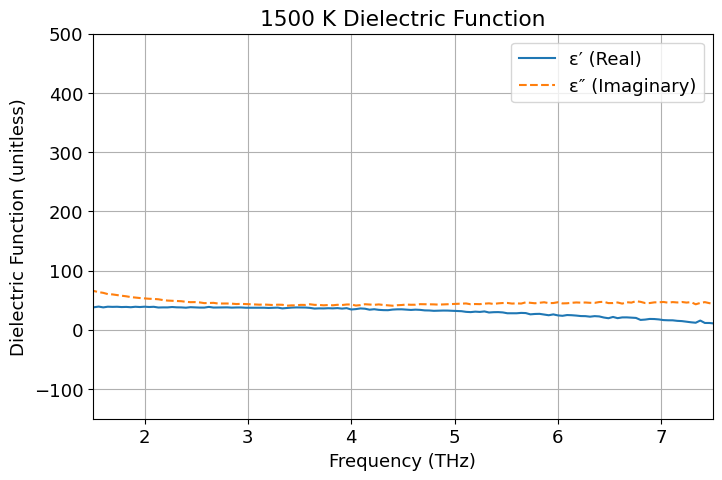

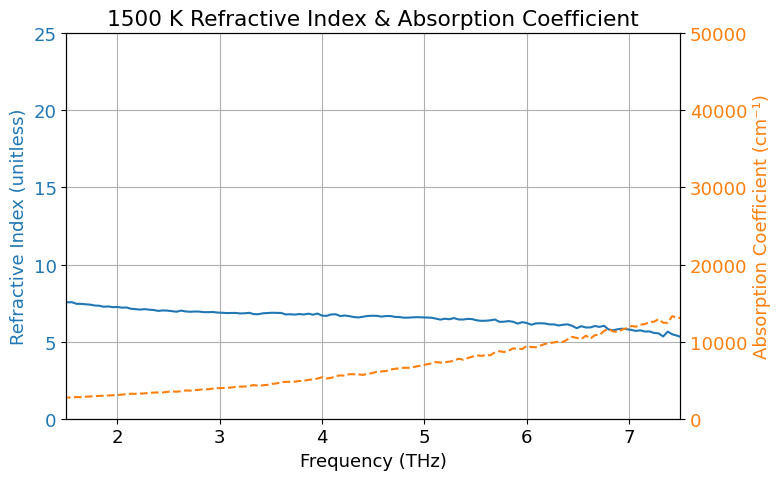

In [34]:
def plot_dielectric_refractive_separately(results, temps_to_plot):
    for result in results:
        temp = result['temp']
        if temp not in temps_to_plot:
            continue

        freqs_cm = result['freqs'] * 1e12 / (speed_c * 100)
        freqs_thz = result['nu'] / 1e12

        # Dielectric Function
        fig_die, ax_die = plt.subplots(figsize=(8, 5))
        ax_die.plot(freqs_thz, result['e_r'], label="ε′ (Real)")
        ax_die.plot(result['nu'] / 1e12, result['e_i'], linestyle='--', label="ε″ (Imaginary)")
        ax_die.set_xlabel('Frequency (THz)')
        ax_die.set_ylabel('Dielectric Function (unitless)')
        ax_die.set_title(f"{temp} K Dielectric Function")
        ax_die.set_xlim(1.5, 7.5)
        ax_die.set_ylim(-150, 500)
        #ax_die.set_ylim(0, 100)
        ax_die.legend()
        ax_die.grid(True)
        fig_die.savefig(f"{temp}_double_dielectric.png", dpi=600)

        # Refractive Index
        fig, ax_left = plt.subplots(figsize=(8, 5))

        # This is the absoprtion coefficient calculated from the refractive index, not the absorption spectrum, should match
        abs_coeff_n = (4*pi*(result['nu']/(speed_c*100))*result['n_i'])

        # Plot refractive index on the left y-axis
        ax_left.plot(freqs_thz, result['n_r'], color='tab:blue', label='Refractive Index')
        ax_left.set_xlabel('Frequency (THz)')
        ax_left.set_ylabel('Refractive Index (unitless)', color='tab:blue')
        ax_left.tick_params(axis='y', labelcolor='tab:blue')
        ax_left.set_xlim(1.5, 7.5)
        ax_left.set_ylim(0, 25)
        #ax_left.set_ylim(0, 10)

        # Create the right y-axis for absorption coefficient
        ax_right = ax_left.twinx()
        ax_right.plot(freqs_thz, abs_coeff_n, color='tab:orange', linestyle='--', label='Absorption Coefficient')
        ax_right.set_ylabel('Absorption Coefficient (cm⁻¹)', color='tab:orange')
        ax_right.tick_params(axis='y', labelcolor='tab:orange')
        ax_right.set_ylim(0, 50000)
        #ax_right.set_ylim(0, 20000)

        # Title and grid
        plt.title(f"{temp} K Refractive Index & Absorption Coefficient")
        ax_left.grid(True)
        fig.savefig(f"{temp}_double_ref_abs.png", dpi=600, bbox_inches='tight')
        fig.tight_layout()

plot_dielectric_refractive_separately(results_all, temps_to_plot=[300, 1300, 1500])